Follow the demo tutorial for basic Deep Convolutional GANs: mnist_gan.ipynb (pytorch)

# Part 1: GAN 

Step1. Load the Fashion MNIST dataset and replace the original dataset used in the demo.

Step2. Train the GAN model to produce images in this new domain.

Step3. Attempt to save and display at least 3 samples produced from your GAN model. Describe and discuss any difficulties faced in this process.

Step4. Save the model weights in the folder to be used later.

Step5. Load the model using the saved weights.

Step 6: Re-train the GAN model to see if you can improve. 

Step 7: Save the model weights without using checkpoints.

Step 8: Load the model weights without using checkpoints.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import imageio
import os
import PIL
import time
from IPython import display

import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from IPython.display import Image
from torchvision.utils import save_image
from tqdm import tqdm



In [4]:
transform = Compose([
    ToTensor(),
    Normalize(mean=(0.5,), std=(0.5,))])

# Load Fashion MNIST dataset
fmnist = FashionMNIST(root='./data', train=True,download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:26<00:00, 1004395.93it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 188798.05it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:06<00:00, 643841.96it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7552387.90it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
img, label = fmnist[0]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)

Label:  9
tensor([[[-1.0000, -1.0000, -1.0000,  0.5137,  0.7882],
         [-0.9765, -1.0000, -0.9059,  0.7176,  0.7255],
         [-0.9529, -1.0000, -0.2235,  0.9137,  0.7412],
         [-1.0000, -1.0000, -0.5686,  0.8510,  0.7882],
         [-1.0000, -1.0000,  0.8588,  0.7725,  0.7020]]])


(tensor(-1.), tensor(1.))

Pixel values shown to range from -1 to 1 as expected. A helper function to denormalize and view raw or generated images can be defined.

In [6]:
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)

Label: 9


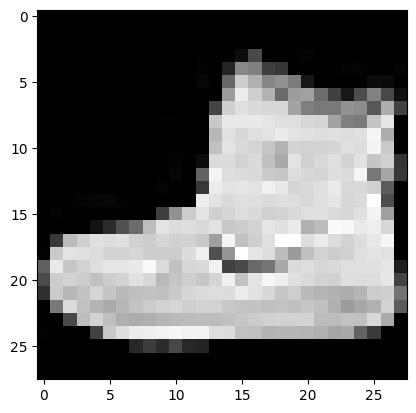

In [7]:

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

Define `dataloader`: a method for loading data efficiently in batches. Also initialize the number of samples per batch and whether input data should be shuffled prior to batching. Shuffling helps to remove any existing ordinal dependency in the data.


In [8]:
batch_size = 100
data_loader = DataLoader(fmnist, batch_size, shuffle=True)

first batch
torch.Size([100, 1, 28, 28])
tensor([5, 6, 0, 5, 7, 1, 1, 1, 5, 5, 8, 9, 6, 4, 8, 1, 4, 4, 1, 6, 6, 3, 1, 1,
        6, 2, 4, 8, 2, 9, 2, 7, 2, 0, 4, 1, 6, 7, 1, 9, 6, 1, 7, 9, 7, 3, 3, 1,
        4, 8, 9, 8, 9, 8, 2, 1, 0, 9, 4, 1, 3, 1, 7, 7, 2, 1, 2, 2, 9, 8, 0, 8,
        1, 2, 7, 1, 7, 5, 8, 5, 0, 1, 0, 5, 4, 5, 8, 7, 4, 0, 3, 1, 2, 6, 5, 8,
        4, 0, 1, 2])


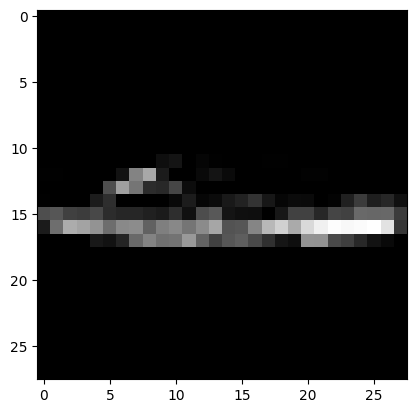

In [9]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Discriminator Network


In Generative Adversarial Netowrks (GANs), the objective of a discriminator network is to distinguish real from generated images produced by the generator network.

In [11]:
image_size = 784
hidden_size = 256

In [12]:

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

In [13]:
D.to(device);

## Generator Network

Inputs for a Generator Network is typically a random noise vector or latext matrix used to initialize a seed for generating a target image. The generator's task is to map points from the input latent space to the target space of the generated images whose outputs should resemble samples from the true data distribution. Effective replication means learning the underlying structure of the data distribution through an adversarial training process with the discriminator.

In [14]:
latent_size = 64
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

Justification for selecting `tanh` as the activation function in the output layer of a generator:
- outputs values in the range (-1,1) which aligns with the range of pixel values in image datasets
- smooth and differential everywhere, suitable for training during back-prop
- zero-centered: output values are symmetric around zero, helps with optimization


In [15]:
y = G(torch.randn(2, latent_size))
gen_imgs = denorm(y.reshape((-1, 28,28)).detach())

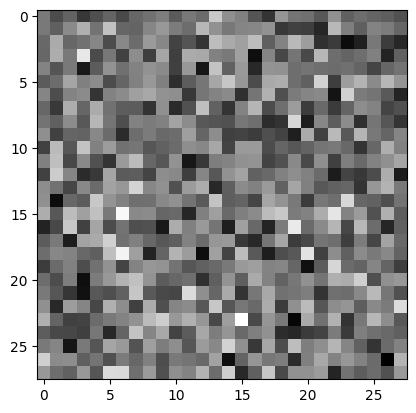

In [16]:
plt.imshow(gen_imgs[0], cmap='gray');

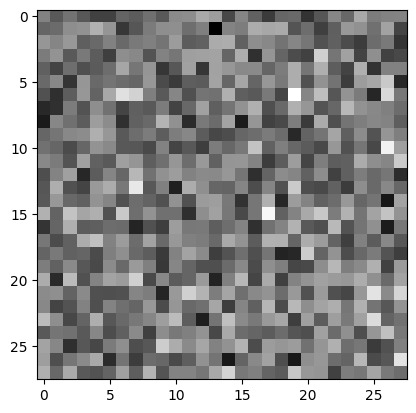

In [17]:
plt.imshow(gen_imgs[1], cmap='gray');

Random noise is expected as output from the generator. A batch of outputs can be saved to a file

In [18]:
G.to(device);

## Discriminator Training

Given that the discriminator's tasks is to classify between real and generated images (comprising 2 classes), the binary cross entropy loss function is well-suited as  it measures the difference between 2 probability distributions: predicted probablity distribution by the discriminator and the true distribution.

In [19]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [20]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_score, fake_score

**Steps for training Discriminator:**
1. Initialize parameters using random weights or using pre-trained weights if available
2. Prepare training sets with real and generated samples
3. Forward Pass #1:
    -   feed a batch of sample images through discriminator network and compute predictions for each sample
    -   calculate loss for real samples using i.e. binary cross entropy loss, measures how well the discriminator can classify real samples as real (label = 1)
    -   perform backpropagation to compute gradients of loss with respect to discriminator's parameters
    -   update parameters using optimization algorithm to minimize loss for real samples
4. Forward pass #2:
    -   generate random noise (fake samples) through generator network  and feed samples to discriminator network
    -   calculate loss for fake samples using same binary cross entropy, measure show well the discriminator can classify fake images as fake (label = 0)
    -   perform backpropagation to compute gradients of loss with repsect to discriminator's parameters
    - update parameters of D network using computed gradients for fake samples to min(loss)
5. Repeat iteratively until equilibirum is met

*The weights of the generator remains unchanged while training the discriminator*


**Steps for training Generator**

A fundamental process for training generators means to use the discriminator's assessments as a critical component of its loss function. The medthod capitalizes on the adversarial relationship between G and D to improve quality of generated images, and to "fool" the D. 

In [21]:
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [22]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

Save sample intermediate outputs from G to visually assess progress of generative model

In [23]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)
    

Collect a batch of real (ground truth) images for visual comparision with generated images

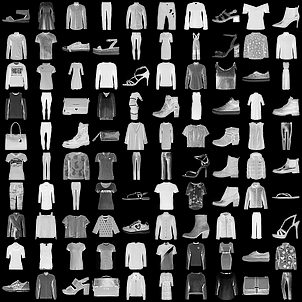

In [24]:


# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=10)
    break

Image(os.path.join(sample_dir, 'real_images.png'))

Helper function to save batches of generated images to disk at each epoch's end. Use a fixed set of input vectors to train G and see how component generated images evolve in quality with each training interation.

Saving fake_images-0000.png


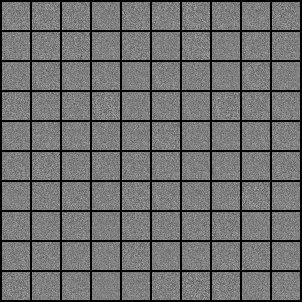

In [25]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [ ]:
device

In each epoch, the D is trained first then the G

In [27]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))

    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/300], Step [200/600], d_loss: 0.0565, g_loss: 4.1832, D(x): 0.99, D(G(z)): 0.05
Epoch [0/300], Step [400/600], d_loss: 0.0763, g_loss: 5.8246, D(x): 0.98, D(G(z)): 0.05
Epoch [0/300], Step [600/600], d_loss: 0.1719, g_loss: 3.8626, D(x): 0.94, D(G(z)): 0.07
Saving fake_images-0001.png
Epoch [1/300], Step [200/600], d_loss: 0.0198, g_loss: 4.7861, D(x): 1.00, D(G(z)): 0.02
Epoch [1/300], Step [400/600], d_loss: 0.1140, g_loss: 4.0147, D(x): 0.97, D(G(z)): 0.03
Epoch [1/300], Step [600/600], d_loss: 0.0309, g_loss: 6.3452, D(x): 0.98, D(G(z)): 0.00
Saving fake_images-0002.png
Epoch [2/300], Step [200/600], d_loss: 0.0258, g_loss: 4.5047, D(x): 1.00, D(G(z)): 0.02
Epoch [2/300], Step [400/600], d_loss: 0.0071, g_loss: 9.5013, D(x): 1.00, D(G(z)): 0.01
Epoch [2/300], Step [600/600], d_loss: 0.0437, g_loss: 5.7399, D(x): 0.98, D(G(z)): 0.02
Saving fake_images-0003.png
Epoch [3/300], Step [200/600], d_loss: 0.0539, g_loss: 6.4875, D(x): 0.99, D(G(z)): 0.02
Epoch [3/300], Step [400/6

Difficulties experience during this training process includes training performance and resource requirements. Unless a specified number of iterations is met, the training can scale in O(n) times given the number of training epochs. There is possible instability during the training process with respect to non-convergence as the loss begins to persistently oscillate - this was immediately observed by the 25th + epoch.

## Step4. Save the model weights in the folder to be used later.

In [28]:
# Save the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

Samples of G's generated images at the 10th, 50th, 100th and 300th epochs

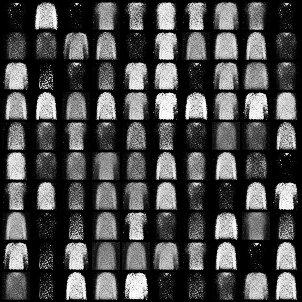

In [29]:
Image('./samples/fake_images-0010.png')

At the 10th epoch, it is mainly noise with hints at reconstruction attempts of clothing artifacts

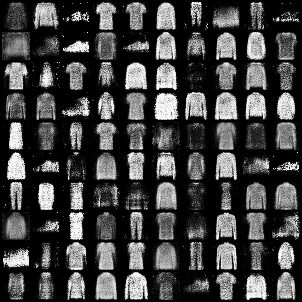

In [30]:
Image('./samples/fake_images-0050.png')

At the 50th epoch, the noise reduces and clothing features become more apparent.

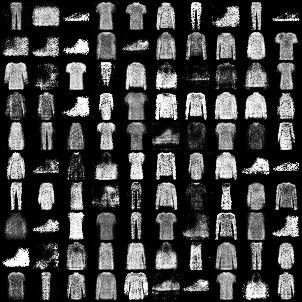

In [31]:
Image('./samples/fake_images-0100.png')

At the 100th epoch, details and creases in the clothing images are more visually clear and visible

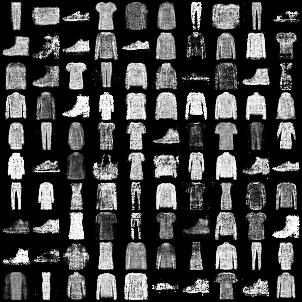

In [32]:
Image('./samples/fake_images-0300.png')

Instability during training is observed with noise reintroduced to the images, particularly in the very top right and bottom left. For instance, the shoes image is occluded with much noise.?

In [34]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'gans_training.mp4'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'mp4v'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training.mp4')

ImportError: libGL.so.1: cannot open shared object file: No such file or directory

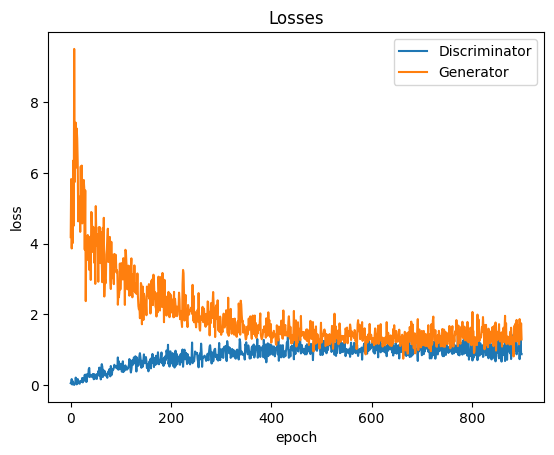

In [35]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

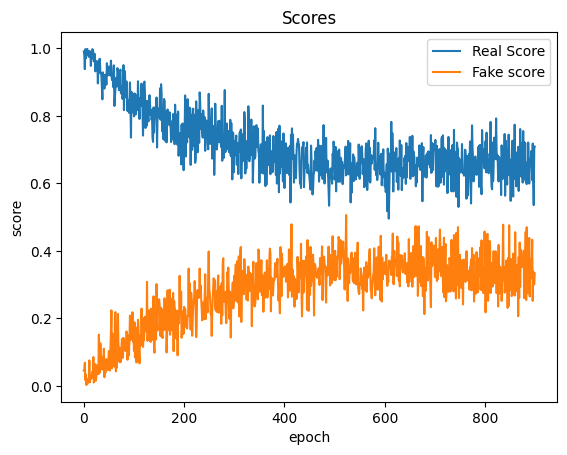

In [36]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [37]:
G.eval(), D.eval()

(Sequential(
   (0): Linear(in_features=64, out_features=256, bias=True)
   (1): ReLU()
   (2): Linear(in_features=256, out_features=256, bias=True)
   (3): ReLU()
   (4): Linear(in_features=256, out_features=784, bias=True)
   (5): Tanh()
 ),
 Sequential(
   (0): Linear(in_features=784, out_features=256, bias=True)
   (1): LeakyReLU(negative_slope=0.2)
   (2): Linear(in_features=256, out_features=256, bias=True)
   (3): LeakyReLU(negative_slope=0.2)
   (4): Linear(in_features=256, out_features=1, bias=True)
   (5): Sigmoid()
 ))

In [38]:
# load the model checkpoints
torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [39]:
# Load the saved weights
G.load_state_dict(torch.load('G.ckpt'))
D.load_state_dict(torch.load('D.ckpt'))

# Set the models to evaluation mode
G.eval(), D.eval()



(Sequential(
   (0): Linear(in_features=64, out_features=256, bias=True)
   (1): ReLU()
   (2): Linear(in_features=256, out_features=256, bias=True)
   (3): ReLU()
   (4): Linear(in_features=256, out_features=784, bias=True)
   (5): Tanh()
 ),
 Sequential(
   (0): Linear(in_features=784, out_features=256, bias=True)
   (1): LeakyReLU(negative_slope=0.2)
   (2): Linear(in_features=256, out_features=256, bias=True)
   (3): LeakyReLU(negative_slope=0.2)
   (4): Linear(in_features=256, out_features=1, bias=True)
   (5): Sigmoid()
 ))

In [40]:
# Move models to the appropriate device if using GPU
# Make sure to define the device variable before this step
G.to(device), D.to(device)

(Sequential(
   (0): Linear(in_features=64, out_features=256, bias=True)
   (1): ReLU()
   (2): Linear(in_features=256, out_features=256, bias=True)
   (3): ReLU()
   (4): Linear(in_features=256, out_features=784, bias=True)
   (5): Tanh()
 ),
 Sequential(
   (0): Linear(in_features=784, out_features=256, bias=True)
   (1): LeakyReLU(negative_slope=0.2)
   (2): Linear(in_features=256, out_features=256, bias=True)
   (3): LeakyReLU(negative_slope=0.2)
   (4): Linear(in_features=256, out_features=1, bias=True)
   (5): Sigmoid()
 ))

In [41]:
%%time

num_epochs = 300
total_step = len(data_loader)
#d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs,num_epochs+num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))
            
    
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [300/300], Step [200/600], d_loss: 1.1005, g_loss: 1.4333, D(x): 0.65, D(G(z)): 0.34
Epoch [300/300], Step [400/600], d_loss: 0.7314, g_loss: 1.8209, D(x): 0.71, D(G(z)): 0.23
Epoch [300/300], Step [600/600], d_loss: 1.0166, g_loss: 1.2895, D(x): 0.65, D(G(z)): 0.33
Saving fake_images-0301.png
Epoch [301/300], Step [200/600], d_loss: 1.0727, g_loss: 1.1691, D(x): 0.68, D(G(z)): 0.38
Epoch [301/300], Step [400/600], d_loss: 0.8726, g_loss: 1.9146, D(x): 0.67, D(G(z)): 0.26
Epoch [301/300], Step [600/600], d_loss: 0.8308, g_loss: 1.4296, D(x): 0.74, D(G(z)): 0.34
Saving fake_images-0302.png
Epoch [302/300], Step [200/600], d_loss: 1.3250, g_loss: 1.1498, D(x): 0.56, D(G(z)): 0.39
Epoch [302/300], Step [400/600], d_loss: 0.9954, g_loss: 1.4684, D(x): 0.63, D(G(z)): 0.28
Epoch [302/300], Step [600/600], d_loss: 1.0704, g_loss: 1.0861, D(x): 0.62, D(G(z)): 0.34
Saving fake_images-0303.png
Epoch [303/300], Step [200/600], d_loss: 1.3524, g_loss: 1.0534, D(x): 0.63, D(G(z)): 0.45
Epoch 

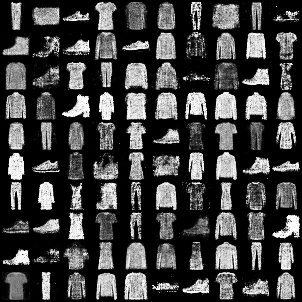

In [42]:
Image('./samples/fake_images-0310.png')

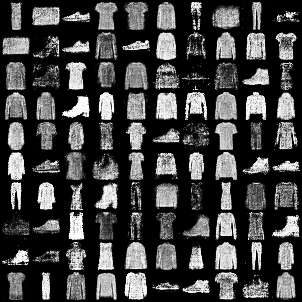

In [43]:
Image('./samples/fake_images-0350.png')

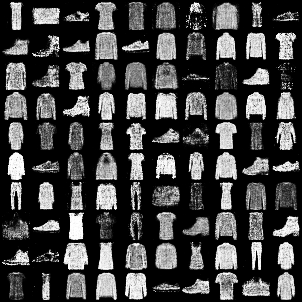

In [44]:
Image('./samples/fake_images-0450.png')

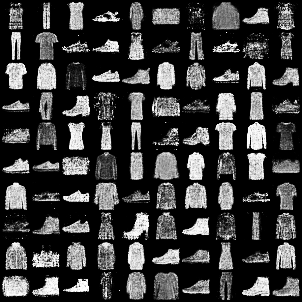

In [138]:
Image('./samples/fake_images-0600.png')

In [45]:

# Save the model weights
torch.save(G.state_dict(), 'G_model_weights.pth')
torch.save(D.state_dict(), 'D_model_weights.pth')

In [46]:
G.load_state_dict(torch.load('G_model_weights.pth'))
D.load_state_dict(torch.load('D_model_weights.pth'))
# Set the model in evaluation mode
G.eval(),D.eval()

(Sequential(
   (0): Linear(in_features=64, out_features=256, bias=True)
   (1): ReLU()
   (2): Linear(in_features=256, out_features=256, bias=True)
   (3): ReLU()
   (4): Linear(in_features=256, out_features=784, bias=True)
   (5): Tanh()
 ),
 Sequential(
   (0): Linear(in_features=784, out_features=256, bias=True)
   (1): LeakyReLU(negative_slope=0.2)
   (2): Linear(in_features=256, out_features=256, bias=True)
   (3): LeakyReLU(negative_slope=0.2)
   (4): Linear(in_features=256, out_features=1, bias=True)
   (5): Sigmoid()
 ))

In [47]:
vid_fname = 'gans_training_600_epochs.mp4'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'mp4v'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('gans_training_600_epochs.mp4')

NameError: name 'cv2' is not defined

In [48]:
len(d_losses),len(g_losses)

(1800, 1800)

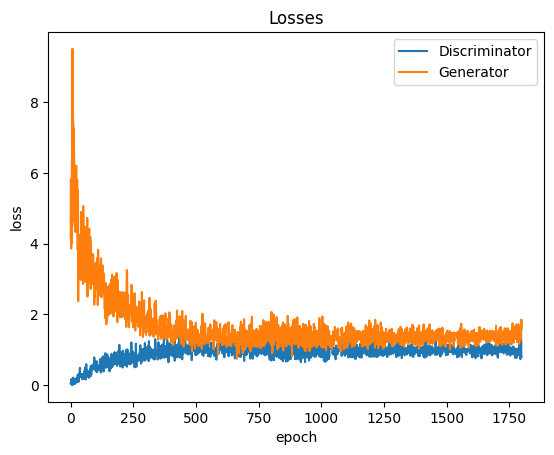

In [49]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

In [50]:
len(real_scores),len(fake_scores)

(1800, 1800)

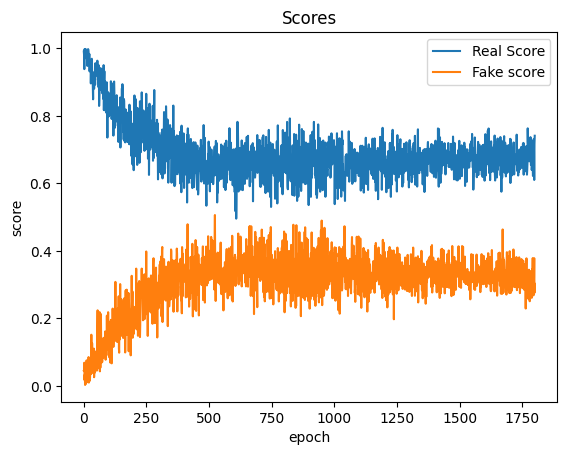

In [51]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

Retraining the basic gain from the 300th epoch checkpoint yields negligibale improvements on loss and accuracy. At a certain threshold, the metrics do not drastically degrade nor improve, with respect to loss or accuracy respectively. Potential remedies could include obtaining more training data, reduce or increase complexity of network, regularization of weights or dropout of connections. 

# Part 2 LSGAN:
Repeat the steps 1-6 with Least Square GAN and compare it with GAN results

In [52]:
    
G_sample_dir = 'generator_samples'
if not os.path.exists(G_sample_dir):
    os.makedirs(G_sample_dir)

In [53]:
batch_size

100

In [54]:
latent_size = 64

general_complexity = 1

G_ls = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    #nn.BatchNorm2d(4 * general_complexity),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    #nn.BatchNorm2d(2 * general_complexity),
    nn.ReLU(),
    #nn.Dropout2d(0.1),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())

G_ls.to(device)

D_ls = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    #nn.BatchNorm2d(general_complexity * 2),
    nn.LeakyReLU(0.2),
    #nn.Dropout2d(0.1),
    nn.Linear(hidden_size, 1))

D_ls.to(device);

In [64]:
criterion = nn.MSELoss()
g_ls_optimizer = torch.optim.Adam(G_ls.parameters(), lr=0.0002)
d_ls_optimizer = torch.optim.Adam(D_ls.parameters(), lr=0.0002)

def reset_grad():
    d_ls_optimizer.zero_grad()
    g_ls_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)

    # Loss for real images
    outputs = D_ls(images)
    d_ls_loss_real = criterion(outputs, real_labels)
    real_ls_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G_ls(z)
    outputs = D_ls(fake_images)
    d_ls_loss_fake = criterion(outputs, fake_labels)
    fake_ls_score = outputs

    # Combine losses
    d_ls_loss = d_ls_loss_real + d_ls_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_ls_loss.backward()
    # Adjust the parameters using backprop
    d_ls_optimizer.step()

    return d_ls_loss, real_ls_score, fake_ls_score

def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G_ls(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_ls_loss = criterion(D_ls(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_ls_loss.backward()
    g_ls_optimizer.step()
    return g_ls_loss, fake_images

# sample_vectors = torch.randn(batch_size, latent_size).to(device)

# def save_fake_images(index):
#     fake_images = G_ls(sample_vectors)
#     fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
#     fake_fname = 'LSGAN_fake_images-{0:0=4d}.png'.format(index)
#     print('Saving', fake_fname)
#     save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)

In [56]:
%%time

num_epochs = 300
total_step = len(data_loader)
d_ls_losses, g_ls_losses, real_ls_scores, fake_ls_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_ls_loss, real_ls_score, fake_ls_score = train_discriminator(images)
        g_ls_loss, fake_ls_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_ls_losses.append(d_ls_loss.item())
            g_ls_losses.append(g_ls_loss.item())
            real_ls_scores.append(real_ls_score.mean().item())
            fake_ls_scores.append(fake_ls_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_ls_loss: {:.4f}, g_ls_loss: {:.4f}, D_ls_(x): {:.2f}, D_ls_(G_ls_(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_ls_loss.item(), g_ls_loss.item(),
                          real_ls_score.mean().item(), fake_ls_score.mean().item()))
    #save
    fake_images = fake_ls_images.reshape(fake_ls_images.size(0), 1, 28, 28)
    fake_fname = 'LSGAN_fake_images-{0:0=4d}.png'.format(epoch+1)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(G_sample_dir, fake_fname), nrow=10)

Epoch [0/300], Step [200/600], d_ls_loss: 0.0054, g_ls_loss: 1.1856, D_ls_(x): 1.00, D_ls_(G_ls_(z)): 0.01
Epoch [0/300], Step [400/600], d_ls_loss: 0.0179, g_ls_loss: 1.4331, D_ls_(x): 1.02, D_ls_(G_ls_(z)): 0.05
Epoch [0/300], Step [600/600], d_ls_loss: 0.0065, g_ls_loss: 1.0734, D_ls_(x): 0.98, D_ls_(G_ls_(z)): -0.00
Saving LSGAN_fake_images-0001.png
Epoch [1/300], Step [200/600], d_ls_loss: 0.0071, g_ls_loss: 1.0722, D_ls_(x): 0.99, D_ls_(G_ls_(z)): 0.02
Epoch [1/300], Step [400/600], d_ls_loss: 0.0047, g_ls_loss: 1.0686, D_ls_(x): 1.00, D_ls_(G_ls_(z)): 0.02
Epoch [1/300], Step [600/600], d_ls_loss: 0.0171, g_ls_loss: 1.0809, D_ls_(x): 1.03, D_ls_(G_ls_(z)): 0.05
Saving LSGAN_fake_images-0002.png
Epoch [2/300], Step [200/600], d_ls_loss: 0.0112, g_ls_loss: 1.1248, D_ls_(x): 0.99, D_ls_(G_ls_(z)): 0.02
Epoch [2/300], Step [400/600], d_ls_loss: 0.0118, g_ls_loss: 1.0603, D_ls_(x): 0.98, D_ls_(G_ls_(z)): 0.00
Epoch [2/300], Step [600/600], d_ls_loss: 0.0094, g_ls_loss: 1.0889, D_ls_(

KeyboardInterrupt: 

In [324]:
# Save the model checkpoints
torch.save(G_ls.state_dict(), 'G_ls.ckpt')
torch.save(D_ls.state_dict(), 'D_ls.ckpt')

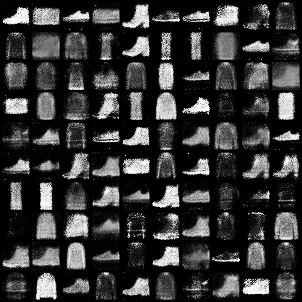

In [342]:
Image('./generator_samples/LSGAN_fake_images-0010.png')

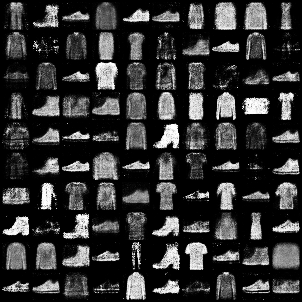

In [343]:
Image('./generator_samples/LSGAN_fake_images-0050.png')

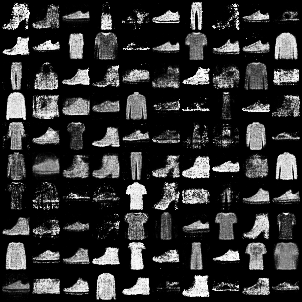

In [345]:
Image('./generator_samples/LSGAN_fake_images-0250.png')

In [346]:
vid_fname = 'lsgans_training_450_epochs.mp4'

files = [os.path.join(G_sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'mp4v'), 8, (302,302))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('lsgans_training_450_epochs.mp4')

[ WARN:0@94421.111] global loadsave.cpp:248 findDecoder imread_('generator_samples/fake_images-0000.png'): can't open/read file: check file path/integrity
[ WARN:0@94421.111] global loadsave.cpp:248 findDecoder imread_('generator_samples/fake_images-0001.png'): can't open/read file: check file path/integrity
[ WARN:0@94421.111] global loadsave.cpp:248 findDecoder imread_('generator_samples/fake_images-0002.png'): can't open/read file: check file path/integrity
[ WARN:0@94421.111] global loadsave.cpp:248 findDecoder imread_('generator_samples/fake_images-0003.png'): can't open/read file: check file path/integrity
[ WARN:0@94421.111] global loadsave.cpp:248 findDecoder imread_('generator_samples/fake_images-0004.png'): can't open/read file: check file path/integrity
[ WARN:0@94421.111] global loadsave.cpp:248 findDecoder imread_('generator_samples/fake_images-0005.png'): can't open/read file: check file path/integrity
[ WARN:0@94421.111] global loadsave.cpp:248 findDecoder imread_('gener

/Users/christopherton/Desktop/SJSU_MSDA/255/DATA255/HW5/lsgans_training_450_epochs.mp4

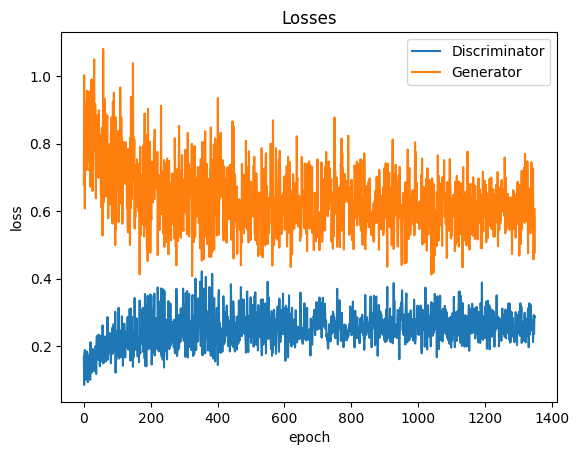

In [347]:
plt.plot(d_ls_losses, '-')
plt.plot(g_ls_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

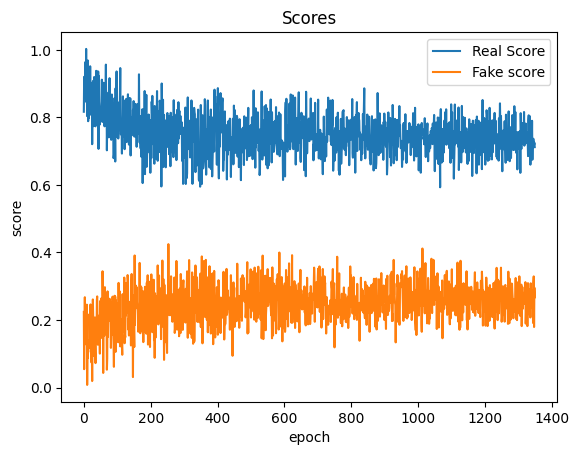

In [348]:
plt.plot(real_ls_scores, '-')
plt.plot(fake_ls_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

In [63]:
# Load the saved weights
G_ls.load_state_dict(torch.load('G_ls.ckpt'))
D_ls.load_state_dict(torch.load('D_ls.ckpt'))

# Set the models to evaluation mode
G_ls.eval(), D_ls.eval()


(Sequential(
   (0): Linear(in_features=64, out_features=256, bias=True)
   (1): ReLU()
   (2): Linear(in_features=256, out_features=256, bias=True)
   (3): ReLU()
   (4): Linear(in_features=256, out_features=784, bias=True)
   (5): Tanh()
 ),
 Sequential(
   (0): Linear(in_features=784, out_features=256, bias=True)
   (1): LeakyReLU(negative_slope=0.2)
   (2): Linear(in_features=256, out_features=256, bias=True)
   (3): LeakyReLU(negative_slope=0.2)
   (4): Linear(in_features=256, out_features=1, bias=True)
 ))

In [65]:
%%time

num_epochs = 450
total_step = len(data_loader)
#d_ls_losses, g_ls_losses, real_ls_scores, fake_ls_scores = [], [], [], []

for epoch in range(num_epochs,num_epochs+300):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)

        # Train the discriminator and generator
        d_ls_loss, real_ls_score, fake_ls_score = train_discriminator(images)
        g_ls_loss, fake_ls_images = train_generator()

        # Inspect the losses
        if (i+1) % 200 == 0:
            d_ls_losses.append(d_ls_loss.item())
            g_ls_losses.append(g_ls_loss.item())
            real_ls_scores.append(real_ls_score.mean().item())
            fake_ls_scores.append(fake_ls_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_ls_loss: {:.4f}, g_ls_loss: {:.4f}, D_ls_(x): {:.2f}, D_ls_(G_ls_(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_ls_loss.item(), g_ls_loss.item(),
                          real_ls_score.mean().item(), fake_ls_score.mean().item()))
    #save
    fake_images = fake_ls_images.reshape(fake_ls_images.size(0), 1, 28, 28)
    fake_fname = 'LSGAN_fake_images-{0:0=4d}.png'.format(epoch+1)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(G_sample_dir, fake_fname), nrow=10)

Epoch [450/450], Step [200/600], d_ls_loss: 0.0070, g_ls_loss: 1.3068, D_ls_(x): 0.97, D_ls_(G_ls_(z)): 0.03
Epoch [450/450], Step [400/600], d_ls_loss: 0.0031, g_ls_loss: 1.1154, D_ls_(x): 0.99, D_ls_(G_ls_(z)): 0.01
Epoch [450/450], Step [600/600], d_ls_loss: 0.0038, g_ls_loss: 1.0969, D_ls_(x): 0.98, D_ls_(G_ls_(z)): 0.02
Saving LSGAN_fake_images-0451.png
Epoch [451/450], Step [200/600], d_ls_loss: 0.0049, g_ls_loss: 1.0681, D_ls_(x): 1.00, D_ls_(G_ls_(z)): 0.04
Epoch [451/450], Step [400/600], d_ls_loss: 0.0034, g_ls_loss: 1.0690, D_ls_(x): 0.99, D_ls_(G_ls_(z)): 0.01
Epoch [451/450], Step [600/600], d_ls_loss: 0.0040, g_ls_loss: 1.0397, D_ls_(x): 1.00, D_ls_(G_ls_(z)): -0.02
Saving LSGAN_fake_images-0452.png
Epoch [452/450], Step [200/600], d_ls_loss: 0.0011, g_ls_loss: 1.0320, D_ls_(x): 1.00, D_ls_(G_ls_(z)): 0.01
Epoch [452/450], Step [400/600], d_ls_loss: 0.0019, g_ls_loss: 1.0156, D_ls_(x): 1.00, D_ls_(G_ls_(z)): 0.00
Epoch [452/450], Step [600/600], d_ls_loss: 0.0005, g_ls_lo

In [72]:
torch.save(G_ls.state_dict(), 'G_ls_model_weights.pth')
torch.save(D_ls.state_dict(), 'D_ls_model_weights.pth')

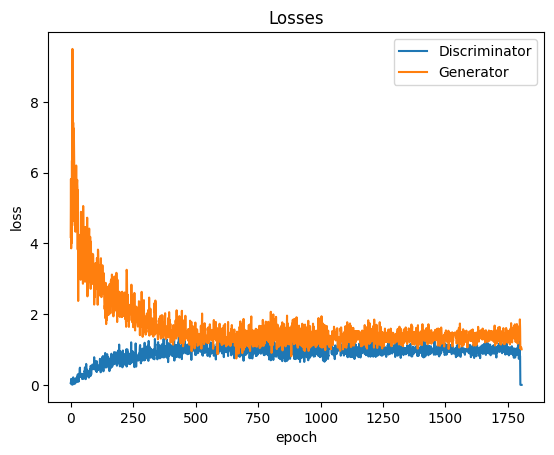

In [67]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

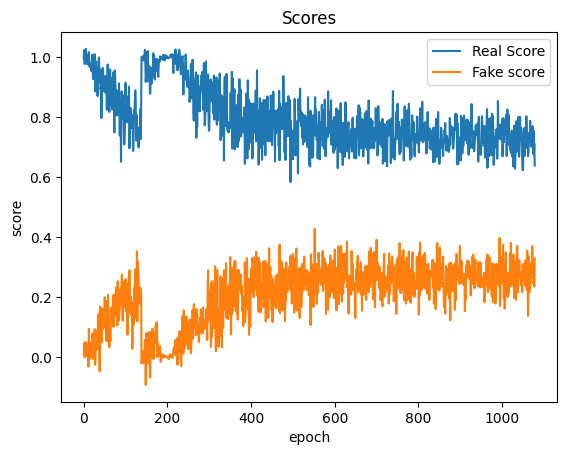

In [68]:
plt.plot(real_ls_scores, '-')
plt.plot(fake_ls_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');

Discriminator and Generator losses degrade as expected after retraining from the 450th epoch, and onwards until the 750th epoch. The real score and fake scores experience some instability at the epochs before the 200th mark then begins to plateau.

In [73]:
G_ls.load_state_dict(torch.load('G_ls_model_weights.pth'))
D_ls.load_state_dict(torch.load('D_ls_model_weights.pth'))
# Set the model in evaluation mode
G_ls.eval(),D_ls.eval()

(Sequential(
   (0): Linear(in_features=64, out_features=256, bias=True)
   (1): ReLU()
   (2): Linear(in_features=256, out_features=256, bias=True)
   (3): ReLU()
   (4): Linear(in_features=256, out_features=784, bias=True)
   (5): Tanh()
 ),
 Sequential(
   (0): Linear(in_features=784, out_features=256, bias=True)
   (1): LeakyReLU(negative_slope=0.2)
   (2): Linear(in_features=256, out_features=256, bias=True)
   (3): LeakyReLU(negative_slope=0.2)
   (4): Linear(in_features=256, out_features=1, bias=True)
 ))

In [295]:
!python main.py --dataset fashion-mnist --gan_type LSGAN --epoch 50 --batch_size 64

---------- Networks architecture -------------
generator(
  (fc): Sequential(
    (0): Linear(in_features=62, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=6272, bias=True)
    (4): BatchNorm1d(6272, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
  )
  (deconv): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Tanh()
  )
)
Total number of parameters: 6640193
discriminator(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1